In [273]:
import scipy as sp
import scipy.sparse
import scipy.sparse.csgraph
import scipy.sparse.linalg
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

/home/hao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  if __name__ == '__main__':


- Generate a disconnected graph W0

In [206]:
# number of points
Ns = [100, 100, 100]
seed = 42

W0s = []
density = 1.0
for Ni in Ns:
    W0s.append(sp.sparse.random(Ni, Ni, density=density, random_state=seed))
W0 = sp.sparse.block_diag(W0s, format='csr')
W0 += W0.T
W0 /= 2
W0 -= sp.sparse.diags(W0.diagonal())

- Add perturbation and compute eigenvalues and eigenvectors of the graph Laplacian

In [207]:
perturb_level = 3
def get_eigs(eps):    
    W = W0.copy()
    shape = W.shape
    for i in range(perturb_level):
        W += eps * (eps**i) \
         * sp.sparse.random(*shape, density=density, format='csr', 
                           random_state=seed)
    # make sure W is symmetric
    W += W.T
    W /= 2
    # remove diagonals
    W -= sp.sparse.diags(W.diagonal())
    L = sp.sparse.csgraph.laplacian(W, normed=True)
    [w, v] = sp.linalg.eigh(L.toarray())
    return w, v

- Setup others

In [208]:
N = sum(Ns)
K = len(Ns)
num_in_each = 1
D0 = np.asarray(np.sum(W0, axis=1)).flatten()**0.5   # normalization for the 
u = np.zeros((N, K))
Chis = np.zeros((N, K))
idx = 0
for l in range(K):
    Chis[idx:idx+Ns[l],l] = D0[idx:idx+Ns[l]]/np.sqrt(Ns[l])
    Chis[idx:idx+Ns[l],l] /= sp.linalg.norm(Chis[idx:idx+Ns[l],l])
    idx += Ns[l]
    
u = Chis#.dot(np.random.randn(K, K))
B = sp.sparse.diags(fid, format='csr')


# $\epsilon = o(\gamma^2)$, $\mathcal{I}$ should look like $\gamma^2$ for $\alpha \ge 1$ and $\tau = \gamma^{1/\alpha}$

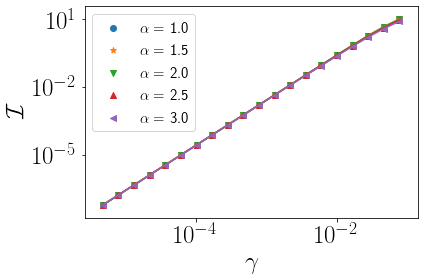

In [227]:
alphas = [1, 1.5, 2, 2.5, 3]
n_alpha = len(alphas)
n = 20
gammas = np.power(0.6, range(5, n+5))

TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

# eps = o(gamma^2)
for j, gamma in enumerate(gammas):
    eps = gamma ** 2.5
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        tau = gamma ** (1/alpha)
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + trCBC + bias ** 2

markers  = ['o','*', 'v', '^', '<', '>', '8', 's', 'p', 'h']
_fontsize = 25
var = gammas
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\gamma$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()

# $\tau^2 = \epsilon, \gamma = \tau^\alpha$? In this case, $\mathcal{I} = O(\tau^{2\alpha} + \tau^4) = O(\epsilon^\alpha + \epsilon^2)$ according to the Corollary 3.10, which does not correspond to $\tau = o(\sqrt{\epsilon})$.

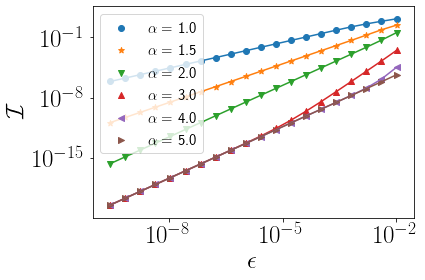

In [274]:
alphas = [1, 1.5, 2, 3, 4, 5]
n_alpha = len(alphas)
n = 20
epss   = np.power(0.4, range(5, n+5))
TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

for j, eps in enumerate(epss):
    
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        tau = eps ** (1/2)
        gamma = tau ** alpha
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + trCBC + bias ** 2

var = epss
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\epsilon$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()

# $\gamma = o(\sqrt{\epsilon}), \tau = \Xi\epsilon^{\frac{1}{2\alpha}}$ (how are we supposed to get $\Xi$?). In this case, $\mathcal{I} = O(\epsilon + \epsilon^{2/\alpha})$ according to theorem 1.3.

I have a couple issues with this case. 

- $\tau$ is not directly tied to $\gamma$ but rather to $\epsilon$, i.e. $\tau = \Xi\epsilon^{\frac{1}{2\alpha}}$, which may break the usual identity $\gamma = \tau^\alpha$ if $\gamma = o(\sqrt{\epsilon})$ instead of $\gamma = \sqrt{\epsilon}$.
- The numerics does not really match up in this case. 
- I don't really see the connection between theorem 1.3 and corrolary 3.10.

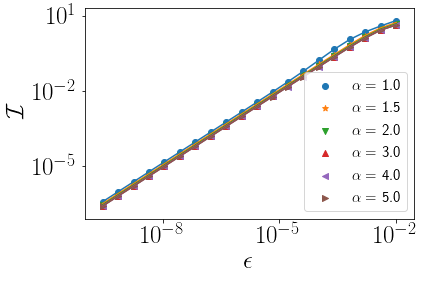

In [277]:
alphas = [1, 1.5, 2, 3, 4, 5]
n_alpha = len(alphas)
n = 20
epss   = np.power(0.4, range(5, n+5))
TRC = np.zeros((n_alpha, n))
TRCBC = np.zeros((n_alpha, n))
BIAS = np.zeros((n_alpha, n))
I = np.zeros((n_alpha, n))

for j, eps in enumerate(epss):
    w, v = get_eigs(eps)
    for i, alpha in enumerate(alphas):
        gamma = eps ** (1/2)
        tau = eps ** (1/(2 * alpha)) * 0.5
        d = (tau ** (2 * alpha)) * np.power(w + tau**2., -alpha)
        d_inv = 1./d  
        prior_inv = v @ sp.sparse.diags(d_inv, format='csr') @ v.T
        # B/gamma^2
        B_over_gamma2 = B / (gamma * gamma)
        # post_inv  : (B/gamma^2 + C_{tau,\eps}^{-1})^{-1}
        post_inv  = prior_inv + B_over_gamma2
        # C^{-1}
        post = post_inv.I
        bias = sp.linalg.norm(post @ B_over_gamma2 @ u - u, ord='fro')
       
        #bias = sp.linalg.norm(post @ prior_inv @ u, ord='fro')
        BIAS[i,j] = bias ** 2
       
        trC = sp.trace(post)
        TRC[i,j] = trC

        post2 = post.dot(post)
        trCBC = sp.trace(post2[np.ix_(labeled[0], labeled[0])])
        TRCBC[i, j] = trCBC/(gamma**2.)
        
        I[i, j] = K * trC + trCBC + bias ** 2

var = epss
target = I

fig = plt.figure()
ax = fig.gca()
ax.loglog(var, target.T)
for i, alpha in enumerate(alphas):
    ax.scatter(var, target[i,:], marker=markers[i], label=r'$\alpha =$ %2.1f'% alpha)
plt.xlabel(r'$\epsilon$', fontsize=_fontsize)
plt.ylabel(r'$\mathcal{I}$', fontsize=_fontsize)
ax.tick_params(axis='both', which='major', labelsize=_fontsize)
plt.legend([r'$\alpha =$ %2.1f'% alpha for alpha in alphas], fontsize=20)
plt.legend(fontsize=15)
plt.tight_layout()